## C elegans example for algorithm comparisons by distortions

### Preparation process
Now we can look at some real examples, C.elegans dataset with data link:\
Ashwin Narayan Datasets https://cb.csail.mit.edu/densvis/datasets/.\
With this dataset, we can look more closely with how our package works. Especially when we are trying to explore the ellipse difference between the DensMAP and UMAP using our package

>Note: If you already have the data and embedding, feel free to skip this part

In [ ]:
import pandas as pd
import numpy as np
data_path = "https://raw.githubusercontent.com/krisrs1128/distortions-data/main/data/c-elegans_qc_final.txt" 
metadata_path = "https://raw.githubusercontent.com/krisrs1128/distortions-data/main/data/c-elegans_qc_final_metadata.txt"

data = np.loadtxt(data_path, delimiter="\t")
metadata = pd.read_csv(metadata_path, sep=",")

Prepare embedding method you want to analyze

In [2]:
import umap
embedding_dumap = umap.UMAP(n_neighbors=10, n_components=2, n_epochs=500, densmap = True).fit_transform(data)
embedding_umap = umap.UMAP(n_neighbors=10, n_components=2, n_epochs=500, densmap = False).fit_transform(data)

Visualize both embedding, we can see differences between UMAP and DenseMap: 

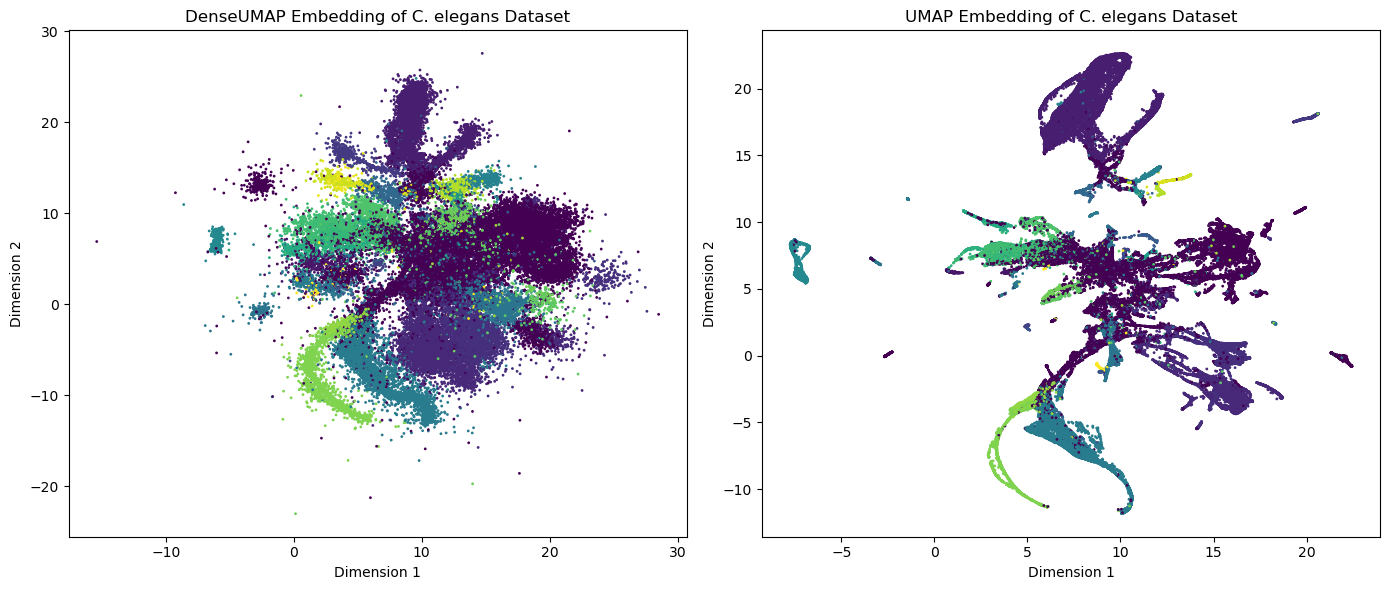

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot DenseUMAP
sc1 = axes[0].scatter(
    embedding_dumap[:, 0], embedding_dumap[:, 1],
    c=pd.Categorical(metadata['cell.type']).codes,
    cmap='viridis', s=1
)
axes[0].set_title("DenseUMAP Embedding of C. elegans Dataset")
axes[0].set_xlabel("Dimension 1")
axes[0].set_ylabel("Dimension 2")

# Plot UMAP
sc2 = axes[1].scatter(
    embedding_umap[:, 0], embedding_umap[:, 1],
    c=pd.Categorical(metadata['cell.type']).codes,
    cmap='viridis', s=1
)
axes[1].set_title("UMAP Embedding of C. elegans Dataset")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

plt.tight_layout()
plt.show()

The dataset is large, so we can take some samples

In [5]:
colors = metadata['cell.type']
cell_picked = metadata.groupby('cell.type').size().sort_values(ascending=False).index[:5].tolist()
from collections import defaultdict
def sampling(source, num_sample, cell_picked):    
    class_indices = defaultdict(list)
    for idx, label in enumerate(source):
        class_indices[label].append(idx)

    rng = np.random.default_rng(seed=42) 
    sampled_indices = []
    for label, indices in class_indices.items():
        if label in cell_picked:
            n_class_samples = min(len(indices), num_sample)
            sampled_indices.extend(rng.choice(indices, n_class_samples, replace=False))
    return sampled_indices
sampled_indices = sampling(colors, 100, cell_picked)

### Distortion analysis
make sure you already has the `distortions` package installed. After you prepare the raw data and the embedding you want to analyze, you can bind them by anndata. 

In [6]:
import distortions
from distortions.geometry import Geometry, bind_metric, local_distortions
from distortions.geometry import neighborhoods
from distortions.visualization import dplot

import anndata as ad
import scanpy as sc

adata = ad.AnnData(X=data[sampled_indices])
adata.X.shape
adata.obsm["X_DUMAP"] = embedding_dumap[sampled_indices]
adata.obsm["X_UMAP"] = embedding_umap[sampled_indices]
adata.obs["cell_type"] = metadata['cell.type'].values[sampled_indices]
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=40, method='gauss') # Use gauss kernel to compute the neighbors and gain the required information for this data


/opt/anaconda3/envs/test/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 100 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


Here is the code that creates the line connections between embeddings and their neighbors from the original dataset, the threshold and outlier_factor both controls the amount brokens we will show the line relations. 

In [7]:
N_DenseMap = neighborhoods(adata, threshold=.2, outlier_factor=2, embed_key="X_DUMAP")
N_UMAP = neighborhoods(adata, threshold=.2, outlier_factor=2, embed_key="X_UMAP")

Prepare the ellipse information, to achieve reasonable results, radius should be small enough to make the sample be one connected component

In [38]:
radius = 20 # To achieve reasonable results, radius should be smaller enought to make the sample be one connected component
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"radius": radius, "n_neighbors": None}, laplacian_kwds={"scaling_epps": radius})

densmap_embed_test = adata.obsm["X_DUMAP"].copy()
H, Hvv, Hs = local_distortions(densmap_embed_test, adata.X, geom)
densmap_embed_test = bind_metric(densmap_embed_test, Hvv, Hs)
densmap_embed_test["cell_type"] = adata.obs["cell_type"].values
summary = {"densmap_kappa": Hs[:, 0] / Hs[:, 1], "densmap_vol": Hs[:, 0] * Hs[:, 1]}

umap_embed_test = adata.obsm["X_UMAP"].copy()
H, Hvv, Hs = local_distortions(umap_embed_test, adata.X, geom)
umap_embed_test = bind_metric(umap_embed_test, Hvv, Hs)
umap_embed_test["cell_type"] = adata.obs["cell_type"].values
summary["umap_kappa"] = Hs[:, 0] / Hs[:, 1]
summary["umap_vol"] = Hs[:, 0] * Hs[:, 1]

Visualization by distortions package

In [39]:
display(dplot(densmap_embed_test, width=600, height=500)\
        .mapping(x="embedding_0", y="embedding_1", color="cell_type")\
        .geom_ellipse(radiusMax=12, radiusMin=2)\
        .scale_color(legendTextSize=8)\
        .labs(x="DensMap 1", y="DensMap 2")\
        .inter_edge_link(N=N_DenseMap, threshold=1, backgroundOpacity=0.4, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=0.1))

display(dplot(umap_embed_test, width=600, height=500)\
        .mapping(x="embedding_0", y="embedding_1", color="cell_type")\
        .geom_ellipse(radiusMax=12, radiusMin=2)\
        .scale_color(legendTextSize=8)\
        .labs(x="UMAP 1", y="UMAP 2")\
        .inter_edge_link(N=N_UMAP, threshold=1, backgroundOpacity=0.4, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=0.1))

/opt/anaconda3/envs/test/lib/python3.13/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
keys must be str, int, float, bool or None, not numpy.int64
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


dplot(dataset=[{'embedding_0': 9.763238906860352, 'embedding_1': 19.878759384155273, 'x0': -0.1523474605577753…

/opt/anaconda3/envs/test/lib/python3.13/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
keys must be str, int, float, bool or None, not numpy.int64
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


dplot(dataset=[{'embedding_0': 7.632808685302734, 'embedding_1': 19.844865798950195, 'x0': 0.38788194936475184…

If you want to see the compress direction more closely, the hair plot is a good choice

In [43]:
display(dplot(densmap_embed_test, width=600, height=500)\
        .mapping(x="embedding_0", y="embedding_1", color="cell_type")\
        .geom_hair(radiusMax=24, radiusMin=2)\
        .scale_color(legendTextSize=8)\
        .labs(x="DensMap 1", y="DensMap 2")\
        .inter_edge_link(N=N_DenseMap, threshold=1, backgroundOpacity=0.4, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=0.1))
display(dplot(umap_embed_test, width=600, height=500)\
        .mapping(x="embedding_0", y="embedding_1", color="cell_type")\
        .geom_hair(radiusMax=24, radiusMin=2)\
        .scale_color(legendTextSize=8)\
        .labs(x="UMAP 1", y="UMAP 2")\
        .inter_edge_link(N=N_DenseMap, threshold=1, backgroundOpacity=0.4, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=0.1))

/opt/anaconda3/envs/test/lib/python3.13/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
keys must be str, int, float, bool or None, not numpy.int64
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


dplot(dataset=[{'embedding_0': 9.763238906860352, 'embedding_1': 19.878759384155273, 'x0': -0.1523474605577753…

/opt/anaconda3/envs/test/lib/python3.13/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
keys must be str, int, float, bool or None, not numpy.int64
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


dplot(dataset=[{'embedding_0': 7.632808685302734, 'embedding_1': 19.844865798950195, 'x0': 0.38788194936475184…

Even not so obvious, we can still see the ellipse generated by the densMap is more uniform. And then we can do a simple counting:

In [42]:
import altair as alt
df_kappa = pd.concat([
    pd.DataFrame({'ratio': np.log(summary["umap_kappa"]), 'method': 'umap', 'cell_type': adata.obs['cell_type']}),
    pd.DataFrame({'ratio': np.log(summary["densmap_kappa"]), 'method': 'densmap'})
])

alt.Chart(df_kappa).mark_bar(opacity=0.5).encode(
    x=alt.X('ratio', bin=alt.Bin(maxbins=50)),
    y=alt.Y('count()', stack=None),
    color=alt.Color('method:N', legend=alt.Legend(title="Method"))
).properties(width=400, height=300)

alt.Chart(...)

By looking the internal isometry information, we can see the local distortion information more clearly, especially provide your a 3d views

By looking at the internal isometry information, we can see the local distortion information more clearly, which expand the 2d visualize information

In [50]:
metrics = {k: H[k] for k in range(len(H))}
dplot(densmap_embed_test, width=600, height=500)\
    .mapping(x="embedding_0", y="embedding_1",color="cell_type")\
    .geom_ellipse(radiusMax=12, radiusMin=2)\
    .inter_isometry(metrics=metrics, metric_bw=1, transformation_bw=0.2, strokeWidth=0.2)\
    .scale_color()\
    .labs(x="DensMap 1", y="DensMap 2")

dplot(dataset=[{'embedding_0': 9.763238906860352, 'embedding_1': 19.878759384155273, 'x0': -0.1523474605577753…

In [49]:
metrics = {k: H[k] for k in range(len(H))}
dplot(umap_embed_test, width=600, height=500)\
    .mapping(x="embedding_0", y="embedding_1", angle="angle", a="s0", b="s1", color="cell_type")\
    .geom_ellipse(radiusMax=12, radiusMin=2)\
    .inter_isometry(metrics=metrics, metric_bw=1, transformation_bw=0.2, strokeWidth=0.2)\
    .scale_color()\
    .labs(x="UMPA 1", y="UMAP 2")

dplot(dataset=[{'embedding_0': 7.632808685302734, 'embedding_1': 19.844865798950195, 'x0': 0.38788194936475184…